# Sarsa & Q-learning

## 规则说明

1. 起始点S，终点G，The Cliff 为悬崖（抽象成一个状态）
2. 每走灰色的一步获得-1奖励，走到 G 点获得100奖励，遇到 The Cliff 获得-100奖励
3. 每一步之后上下左右4种action，遇到墙壁则返回当前状态，遇到 The Cliff 则直接返回 S 状态

## 目标
1. 通过 model free 的 Saras 和 Q-learin 方式训练 agent 从 S 走到 G

![title](the_cliff.png)

## Envirement 类

![title](state.png)

In [182]:
import numpy as np
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

In [115]:
# State -> s:[up, down, left, right]
S = {
    0: np.array([21,0,0,31]),
    1: np.array([1,11,1,2]),
    2: np.array([2,12,1,3]),
    3: np.array([3,13,2,4]),
    4: np.array([4,14,3,5]),
    5: np.array([5,15,4,6]),
    6: np.array([6,16,5,7]),
    7: np.array([7,17,6,8]),
    8: np.array([8,18,7,9]),
    9: np.array([9,19,8,10]),
    10: np.array([10,20,9,10]),
    11: np.array([1,21,11,12]),
    12: np.array([2,22,11,13]),
    13: np.array([3,23,12,14]),
    14: np.array([4,24,13,15]),
    15: np.array([5,25,14,16]),
    16: np.array([6,26,15,17]),
    17: np.array([7,27,16,18]),
    18: np.array([8,28,17,19]),
    19: np.array([9,29,18,20]),
    20: np.array([10,30,19,20]),
    21: np.array([11,0,21,22]),
    22: np.array([12,31,21,23]),
    23: np.array([13,31,22,24]),
    24: np.array([14,31,23,25]),
    25: np.array([15,31,24,26]),
    26: np.array([16,31,25,27]),
    27: np.array([17,31,26,28]),
    28: np.array([18,31,27,29]),
    29: np.array([19,31,28,30]),
    30: np.array([20,32,29,30]),
    31: np.array([0,0,0,0]),
    32: np.array([32,32,32,32]),
}

In [116]:
# Reward
R = {x:-1 for x in range(33)}
R[32] = 100
R[31] = -100

## Envirement 类

In [271]:
class Envirement():
    def __init__(self, start, end, reward, transition):
        self.start = start
        self.end = end
        self.reward = reward
        self.transition = transition
        self.state_value = {x:0 for x in self.transition.keys()}
        self.update_sep = []
        
    def sample_one_step(self, state, agent_action):
        next_state = self.transition[state][agent_action]
        return next_state

    def updata_state_value_by_MC_policy_evaluation(self, state_sep, gamma):
        count_state = defaultdict(int)
        
        for idx, s in enumerate(state_sep):
            count_state[s] += 1
            current_gamma = gamma
            Gt = self.reward[s]
            
            # 计算 R_t+1 到 R_end
            for next_s in state_sep[idx+1:]: 
                Gt += self.reward[next_s] * current_gamma
                current_gamma = current_gamma * gamma
                
            # Incremental Monte-Carlo Updates
            self.state_value[s] = self.state_value[s] + 1/count_state[s] * (Gt - self.state_value[s])
            
    def updata_state_value_by_TD_policy_evaluation(self, state_sep, gamma, alpha):
        for idx, s in enumerate(state_sep[:-1]):
            next_s = state_sep[idx+1]
            TD_error = self.reward[s] + gamma * self.state_value[next_s] - self.state_value[s]
            self.state_value[s] = self.state_value[s] + alpha * TD_error
        
        # 序列最后一个状态价值就是自身的 reward    
        self.state_value[state_sep[-1]] = self.reward[state_sep[-1]]
        
        
        
    def show_path(self, seq):
        row1 = {x:(x-1, 3) for x in range(1, 11)}
        row2 = {x:(x-11, 2) for x in range(11, 21)}
        row3 = {x:(x-21, 1) for x in range(21, 31)}
        location_dict = {0:(0,0), 32:(9, 0)}
        location_dict.update(row1)
        location_dict.update(row2)
        location_dict.update(row3)
        x = []
        y = []
        for i in seq:
            x.append(location_dict[i][0]+0.5)
            y.append(location_dict[i][1]+0.5)

        plt.figure(figsize=(16,4))
        plt.plot(x,y, linewidth=10)

        for i in location_dict:
            plt.text(location_dict[i][0]+0.5, location_dict[i][1]+0.5, i, fontsize=30, horizontalalignment='center', verticalalignment='center', alpha=0.5)

        for i, j in enumerate('thecliff'):
            plt.text(i+1+0.5, 0.5, j, fontsize=30, horizontalalignment='center', verticalalignment='center')

        plt.xlim(0,1)
        plt.ylim(0,4)
        plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
        plt.yticks([0,1,2,3,4])
        plt.grid()
        plt.show()

## Agent 类

In [247]:
class Agent():
    def __init__(self):
        self.action = {0:'up', 1:'down', 2:'left', 3:'right'}
        self.Q = {0:{0:0, 1:0, 2:0, 3:0}, 32: {0:100, 1:100, 2:100, 3:100}} # 初始化结束状态的 Q 函数
    
    
    # 根据环境作出行为action
    def get_action(self, state, e_greedy=False, e=0.8):
        if state not in self.Q:
            self.init_Q(state)
        
        if e_greedy:
            p = self.get_egreedy_policy(state, e)
            action = np.random.choice(list(self.action.keys()), p=p)
        else:
            action = self.get_max_Q_action(state)
        return action
    
    
    # sarsa TD 方法更新 Q_table
    def sarsa_TD_update(self, current_state, current_action, reward, next_state, next_action, alpha, gamma):
        
        # 如果没有 Q 函数则初始化
        if not current_state in self.Q:
            self.init_Q(current_state)
            
        if not next_state in self.Q:
            self.init_Q(next_state)
            
        TD_error = reward + gamma * self.Q[next_state][next_action] - self.Q[current_state][current_action]
        self.Q[current_state][current_action] = self.Q[current_state][current_action] + alpha * TD_error
    
    
    # GILE Monte-Carlo 方法更新 Q_table
    def GILE_MC_update(self, episode_seq, action_seq, reward_seq, gamma):
        # 初始化 N  
        N = {0:{0:0, 1:0, 2:0, 3:0}, 32: {0:0, 1:0, 2:0, 3:0}}
        for idx, (state, action) in enumerate(zip(episode_seq, action_seq)):
            if state not in N:
                N[state] = {0:0, 1:0, 2:0, 3:0}
            
            N[state][action] += 1
            
            # 计算Gt
            Gt = reward_seq[idx]
            current_gamma = gamma
            for reward in reward_seq[idx+1:]:
                Gt += current_gamma * reward
                current_gamma = current_gamma * gamma
            
            # Q_table 更新
            self.Q[state][action] = self.Q[state][action] + 1 / N[state][action] * (Gt - self.Q[state][action])
        
    # Q-Learing 方法更新 Q_table
    def Q_learning_update(self, current_state, current_action, reward, next_state, alpha, gamma):
        
        # 如果没有 Q 函数则初始化
        if not current_state in self.Q:
            self.init_Q(current_state)
            
        if not next_state in self.Q:
            self.init_Q(next_state) 
        
        # 获取下一状态最大 action 的 value
        max_value_action = self.get_max_Q_action(next_state)
        mxx_value = self.Q[next_state][max_value_action]
        
        # 更新公式
        TD_error = reward + gamma * mxx_value - self.Q[current_state][current_action]
        self.Q[current_state][current_action] = self.Q[current_state][current_action] + alpha * TD_error
    
    
    # 展示训练结果
    def solve(self, envirement):
        # 训练结果
        current_state = envirement.start 
        current_action = self.get_action(current_state, e_greedy=False) 

        seq = [current_state]

        while current_state != envirement.end:
            print('{} -> '.format(current_state), end='')
            next_state = envirement.sample_one_step(current_state, current_action)
            next_action = self.get_action(next_state, e_greedy=False) 
            seq.append(next_state)

            # 进入下一个step
            current_state = next_state
            current_action = next_action

        print(seq[-1])
        return seq
    
    
    # 初始化Q
    def init_Q(self, state):
        self.Q[state] = {0:0, 1:0, 2:0, 3:0}
    
    
    # 获取 e-greedy 的策略概率
    def get_egreedy_policy(self, state, e):
        p = (np.ones(shape=len(self.action)) / len(self.action)) * e
        
        max_action_value = -float('inf')
        for idx, action in enumerate(self.Q[state]):
            if self.Q[state][action] > max_action_value:
                max_action_value = self.Q[state][action]
                max_action_idx = idx

        p[max_action_idx] += 1 - e
        return p
    
    
    # 获取 Q_value 最大的 action
    def get_max_Q_action(self, state):
        max_q_value = -float('inf')
        
        for action in self.Q[state]:
            if self.Q[state][action] > max_q_value:
                max_q_value = self.Q[state][action]
                optimal_action = action
        
        return optimal_action

## On-Policy

### GLIE Monte-Carlo (MC)

$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+\frac{1}{N(S_t,A_t)}(G_t-Q(S_t,A_t))$

0 -> 21 -> 11 -> 12 -> 13 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 20 -> 30 -> 32


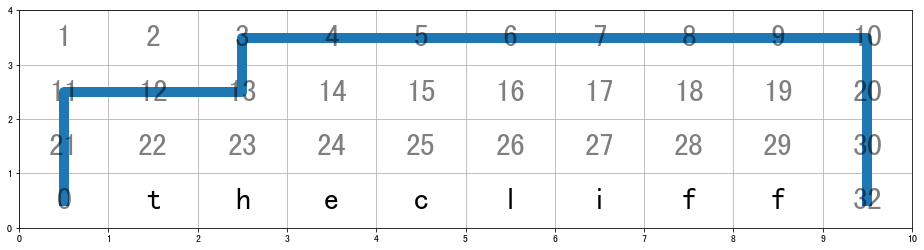

In [274]:
# 初始化 agent 和 envirement
agent = Agent()
envirement = Envirement(0, 32, R, S)

# 超参数
epoch = 500
k = 1
e = 1
gamma = 0.9

for i in range(epoch):
    # MCTS 采样
    current_state = envirement.start # 初始化第一个状态
    current_action = agent.get_action(current_state, e_greedy=True, e=e) # 根据 envirement 的 state 状态作出 action egreedy方式

    # 记录采样序列
    episode_seq = [current_state]
    action_seq = [current_action]
    reward_seq = [envirement.reward[current_state]]

    # 采样一个完整序列
    while current_state != envirement.end:

        next_state = envirement.sample_one_step(current_state, current_action)
        next_reward = envirement.reward[next_state]
        next_action = agent.get_action(next_state, e_greedy=True, e=e)     

        episode_seq.append(next_state)
        action_seq.append(next_action)
        reward_seq.append(next_reward)

        current_state = next_state
        current_action = next_action
        
        # 防止进入死循环
        if len(episode_seq)  > 5000:
            break

    # GILE Monte-Carlo 更新
    agent.GILE_MC_update(episode_seq, action_seq, reward_seq, gamma)

    k += 0.1
    e = 1 / k
    print(i+1, end='\r', flush=True)
    
# 结果
envirement.show_path((agent.solve(envirement)))

# Sarsa Algorithm (TD)

$Q(S,A) \leftarrow Q(S,A)+\alpha(R+\gamma Q(S^{\prime},A^{\prime})-Q(S,A))$

Sarsa TD 的方法需要一个五元组 $(S,A,R,S^{\prime},A^{\prime},)$

0 -> 21 -> 22 -> 12 -> 2 -> 3 -> 4 -> 14 -> 15 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 20 -> 30 -> 32


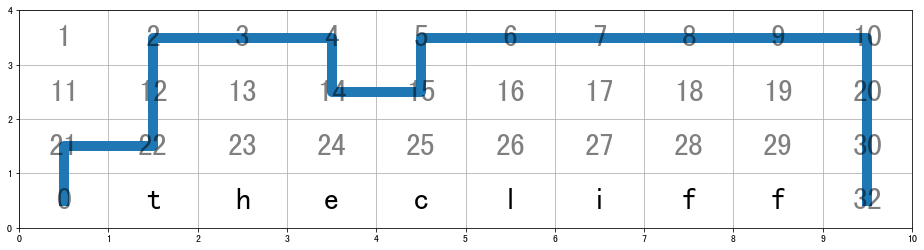

In [273]:
# 初始化 agent 和 envirement
agent = Agent()
envirement = Envirement(0, 32, R, S)

# 超参数
epoch = 500
k = 1
e = 1
alpha = 0.9
gamma = 0.9

# 训练
for i in range(epoch):
    
    # MCTS 采样
    current_state = envirement.start # 初始化第一个状态
    current_action = agent.get_action(current_state, e_greedy=True, e=e) # 根据 envirement 的 state 状态作出 action egreedy方式
    
    step = 0
    while current_state != envirement.end:

        # 获取五元组另外三个元素
        reward = envirement.reward[current_state]  # 当前状态的 reward
        next_state = envirement.sample_one_step(current_state, current_action) # 根据 agent 的 action 给出下一个 state
        next_action = agent.get_action(next_state, e_greedy=True, e=e) # 根据下一个 state 给出 下一个 state 的 action

        # saras TD 进行 Q函数更新
        agent.sarsa_TD_update(current_state, current_action, reward, next_state, next_action, alpha, gamma)

        # 进入下一个step
        current_state = next_state
        current_action = next_action
        
        if step > 5000:
            break
        step += 1

    k += 0.1   
    e = 1 / k
    print(i+1, end='\r', flush=True)
    
# 结果
envirement.show_path((agent.solve(envirement)))

### Q-Learing

$Q(S,A) \leftarrow Q(S,A)+\alpha(r+\gamma argmax_{a^{\prime}}Q(S^{\prime},A^{\prime})-Q(S,A))$

0 -> 21 -> 22 -> 23 -> 24 -> 25 -> 26 -> 27 -> 28 -> 29 -> 30 -> 32


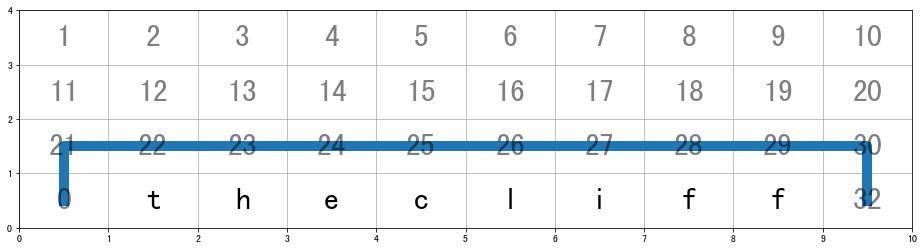

In [272]:
# 初始化 agent 和 envirement
agent = Agent()
envirement = Envirement(0, 32, R, S)

# 超参数
epoch = 500
k = 1
e = 1
alpha = 0.9
gamma = 0.9

# 训练
for i in range(epoch):
    
    # MCTS 采样
    current_state = envirement.start # 初始化第一个状态
    current_action = agent.get_action(current_state, e_greedy=True, e=e) # 根据 envirement 的 state 状态作出 action egreedy方式
    
    step = 0
    while current_state != envirement.end:

        reward = envirement.reward[current_state]  # 当前状态的 reward
        next_state = envirement.sample_one_step(current_state, current_action) # 根据 agent 的 action 给出下一个 state
        next_action = agent.get_action(next_state, e_greedy=True, e=e) # 根据下一个 state 给出 下一个 state 的 action

        # Q_learning 进行 Q函数更新
        agent.Q_learning_update(current_state, current_action, reward, next_state, alpha, gamma)

        # 进入下一个step
        current_state = next_state
        current_action = next_action
        
        if step > 5000:
            break
        step += 1

    k += 0.1   
    e = 1 / k
    print(i+1, end='\r', flush=True)
    
# 结果
envirement.show_path((agent.solve(envirement)))

## Off-Policy